In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Session 4 - Introduction to Spatial Interpolation<img src="./Resources/sla.png" width="100" align ="right"/>

Spatial interpolation is the procedure of estimating the value of properties at unsampled sites within the area covered by existing observations.

In statistics, originally in geostatistics, kriging or Kriging, also known as Gaussian process regression, is a method of interpolation based on Gaussian process governed by prior covariances. The basic idea of kriging is to predict the value of a function at a given point by computing a weighted average of the known values of the function in the neighborhood of the point.

The theoretical basis for the method was developed by the French mathematician *Georges Matheron* in 1960, based on the Master's thesis of Danie G. Krige, the pioneering plotter of distance-weighted average gold grades at the Witwatersrand reef complex in South Africa. Krige sought to estimate the most likely distribution of gold based on samples from a few boreholes. The English verb is to krige and the most common noun is kriging; both are often pronounced with a hard "g", following an Anglicized pronunciation of the name "Krige". The word is sometimes capitalized as Kriging in the literature.

In [2]:
import sys
import os

sys.path.append(r'C:\Program Files\QGIS 3.20.0\apps\qgis\python') #this is important for loading qgis library
sys.path.append(r'C:\Program Files\QGIS 3.20.0\apps\qgis\python\plugins') #this is important for loading processing library

In [3]:
import qgis
from qgis.gui import *
from qgis.core import *
from qgis.utils import plugins
from PyQt5.QtCore import *
from qgis.analysis import QgsNativeAlgorithms

In [101]:
import pandas as pd
import numpy as np
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
import matplotlib.pyplot as plt
import seaborn as sb
import gstools as gs

## Download Singapore Rainfall Data

In [13]:
from datetime import datetime
import json
from pandas import json_normalize
import requests
dt_string = "2020-12-01" 

format = "%Y-%m-%d"
dt_object = datetime.strptime(dt_string, format)
dt_object.date()
datelist = pd.date_range(dt_object.date(), periods=10).tolist()

# download 10 days Singapore rainfall data
# responses = [requests.get('https://api.data.gov.sg/v1/environment/rainfall?date='+i.strftime("%Y-%m-%d")) for i in datelist]
# [print(i.status_code) for i in responses]

# for i,response in enumerate(responses):
#     with open(f'Data/Rainfall/test{i}.json', 'w') as f:
#         json.dump(response.json(), f)

In [14]:
import os
responses_json =[]
for filename in os.listdir('Data/Rainfall'):
    with open(os.path.join('Data/Rainfall', filename), 'r') as f: # open in readonly mode
        response = json.load(f)
        responses_json.append(response)

## Preprocessing Rainfall Data

In [16]:
# df_dict=responses[0].json() # if use online download
df_dict=responses_json[0] # if read files

In [17]:
df_dict['metadata']['stations']

[{'id': 'S77',
  'device_id': 'S77',
  'name': 'Alexandra Road',
  'location': {'latitude': 1.2937, 'longitude': 103.8125}},
 {'id': 'S117',
  'device_id': 'S117',
  'name': 'Banyan Road',
  'location': {'latitude': 1.256, 'longitude': 103.679}},
 {'id': 'S90',
  'device_id': 'S90',
  'name': 'Bukit Timah Road',
  'location': {'latitude': 1.3191, 'longitude': 103.8191}},
 {'id': 'S61',
  'device_id': 'S61',
  'name': 'Chai Chee Street',
  'location': {'latitude': 1.323, 'longitude': 103.9217}},
 {'id': 'S114',
  'device_id': 'S114',
  'name': 'Choa Chu Kang Avenue 4',
  'location': {'latitude': 1.38, 'longitude': 103.73}},
 {'id': 'S11',
  'device_id': 'S11',
  'name': 'Choa Chu Kang Road',
  'location': {'latitude': 1.3746, 'longitude': 103.6938}},
 {'id': 'S50',
  'device_id': 'S50',
  'name': 'Clementi Road',
  'location': {'latitude': 1.3337, 'longitude': 103.7768}},
 {'id': 'S107',
  'device_id': 'S107',
  'name': 'East Coast Parkway',
  'location': {'latitude': 1.3135, 'longitude

In [18]:
df_stations = pd.DataFrame(df_dict['metadata']['stations'])

In [19]:
df_stations

,id,device_id,name,location
0,S77,S77,Alexandra Road,"{'latitude': 1.2937, 'longitude': 103.8125}"
1,S117,S117,Banyan Road,"{'latitude': 1.256, 'longitude': 103.679}"
2,S90,S90,Bukit Timah Road,"{'latitude': 1.3191, 'longitude': 103.8191}"
3,S61,S61,Chai Chee Street,"{'latitude': 1.323, 'longitude': 103.9217}"
4,S114,S114,Choa Chu Kang Avenue 4,"{'latitude': 1.38, 'longitude': 103.73}"
...,...,...,...,...
70,S230,S230,S230,"{'latitude': 1.30167, 'longitude': 103.76444}"
71,S92,S92,South Buona Vista Road,"{'latitude': 1.2841, 'longitude': 103.7886}"
72,S29,S29,Pasir Ris Drive 12,"{'latitude': 1.387, 'longitude': 103.935}"
73,S122,S122,Sembawang Road,"{'latitude': 1.41731, 'longitude': 103.8249}"


In [20]:
df_st= df_stations.drop('location', axis=1).join(pd.DataFrame(df_stations.location.values.tolist()))
df_st

,id,device_id,name,latitude,longitude
0,S77,S77,Alexandra Road,1.29370,103.81250
1,S117,S117,Banyan Road,1.25600,103.67900
2,S90,S90,Bukit Timah Road,1.31910,103.81910
3,S61,S61,Chai Chee Street,1.32300,103.92170
4,S114,S114,Choa Chu Kang Avenue 4,1.38000,103.73000
...,...,...,...,...,...
70,S230,S230,S230,1.30167,103.76444
71,S92,S92,South Buona Vista Road,1.28410,103.78860
72,S29,S29,Pasir Ris Drive 12,1.38700,103.93500
73,S122,S122,Sembawang Road,1.41731,103.82490


In [21]:
# uncomment the following line if you use online requests
# df_rainfall = [pd.DataFrame(response.json()['items']).assign(Day_ID=i+1, Time_ID = pd.DataFrame(response.json()['items']).index+1) for i,response in enumerate(responses)]

# uncomment the next line if you use files in rainfall folder
df_rainfall = [pd.DataFrame(response['items']).assign(Day_ID=i+1, Time_ID = pd.DataFrame(response['items']).index+1) for i,response in enumerate(responses_json)]

In [22]:
df_rainfall_all =pd.concat(df_rainfall, axis=0)

In [23]:
df_rainfall_all

,timestamp,readings,Day_ID,Time_ID
0,2020-12-01T00:05:00+08:00,"[{'station_id': 'S77', 'value': 0}, {'station_...",1,1
1,2020-12-01T00:10:00+08:00,"[{'station_id': 'S77', 'value': 0}, {'station_...",1,2
2,2020-12-01T00:15:00+08:00,"[{'station_id': 'S77', 'value': 0}, {'station_...",1,3
3,2020-12-01T00:20:00+08:00,"[{'station_id': 'S77', 'value': 0}, {'station_...",1,4
4,2020-12-01T00:25:00+08:00,"[{'station_id': 'S77', 'value': 0}, {'station_...",1,5
...,...,...,...,...
282,2020-12-10T23:35:00+08:00,"[{'station_id': 'S77', 'value': 0}, {'station_...",10,283
283,2020-12-10T23:40:00+08:00,"[{'station_id': 'S77', 'value': 0}, {'station_...",10,284
284,2020-12-10T23:45:00+08:00,"[{'station_id': 'S77', 'value': 0}, {'station_...",10,285
285,2020-12-10T23:50:00+08:00,"[{'station_id': 'S77', 'value': 0}, {'station_...",10,286


In [24]:
df = pd.concat([pd.DataFrame(row.readings).assign(Day_ID=row.Day_ID,Time_ID=row.Time_ID) for index, row in df_rainfall_all.iterrows()]).reset_index()
df

,index,station_id,value,Day_ID,Time_ID
0,0,S77,0.0,1,1
1,1,S117,0.0,1,1
2,2,S90,0.0,1,1
3,3,S61,0.0,1,1
4,4,S114,0.0,1,1
...,...,...,...,...,...
211283,68,S08,0.0,10,287
211284,69,S116,0.0,10,287
211285,70,S104,0.0,10,287
211286,71,S100,0.0,10,287


In [25]:
df_agg= df.groupby(['Day_ID','station_id']).sum().drop(['Time_ID','index'],axis=1).reset_index()

In [26]:
df_agg

,Day_ID,station_id,value
0,1,S07,0.0
1,1,S08,0.0
2,1,S100,0.0
3,1,S104,0.0
4,1,S107,0.0
...,...,...,...
747,10,S90,5.6
748,10,S900,43.6
749,10,S91,19.8
750,10,S92,5.6


In [27]:
df_stations

,id,device_id,name,location
0,S77,S77,Alexandra Road,"{'latitude': 1.2937, 'longitude': 103.8125}"
1,S117,S117,Banyan Road,"{'latitude': 1.256, 'longitude': 103.679}"
2,S90,S90,Bukit Timah Road,"{'latitude': 1.3191, 'longitude': 103.8191}"
3,S61,S61,Chai Chee Street,"{'latitude': 1.323, 'longitude': 103.9217}"
4,S114,S114,Choa Chu Kang Avenue 4,"{'latitude': 1.38, 'longitude': 103.73}"
...,...,...,...,...
70,S230,S230,S230,"{'latitude': 1.30167, 'longitude': 103.76444}"
71,S92,S92,South Buona Vista Road,"{'latitude': 1.2841, 'longitude': 103.7886}"
72,S29,S29,Pasir Ris Drive 12,"{'latitude': 1.387, 'longitude': 103.935}"
73,S122,S122,Sembawang Road,"{'latitude': 1.41731, 'longitude': 103.8249}"


In [40]:
df_agg_for_kriging = df_agg.merge(df_st,left_on='station_id',right_on='device_id')

In [41]:
df_agg_for_kriging

,Day_ID,station_id,value,id,device_id,name,latitude,longitude
0,1,S07,0.00000,S07,S07,Lornie Road,1.3415,103.8334
1,2,S07,0.20000,S07,S07,Lornie Road,1.3415,103.8334
2,3,S07,33.00000,S07,S07,Lornie Road,1.3415,103.8334
3,4,S07,21.40000,S07,S07,Lornie Road,1.3415,103.8334
4,5,S07,0.20000,S07,S07,Lornie Road,1.3415,103.8334
...,...,...,...,...,...,...,...,...
736,6,S94,0.00000,S94,S94,Pasir Ris Street 51,1.3662,103.9528
737,7,S94,19.00000,S94,S94,Pasir Ris Street 51,1.3662,103.9528
738,8,S94,0.00000,S94,S94,Pasir Ris Street 51,1.3662,103.9528
739,9,S94,64.19999,S94,S94,Pasir Ris Street 51,1.3662,103.9528


## Visualize Rainfall data

In [31]:
import geopandas as gp

In [42]:
df_rainfall_geoms = gp.points_from_xy(x=df_agg_for_kriging["longitude"],
                                    y=df_agg_for_kriging["latitude"],
                                    crs="epsg:4326"
                                   )

In [43]:
rainfall = gp.GeoDataFrame(df_agg_for_kriging,
                                   geometry=df_rainfall_geoms
                                  )

In [44]:
# ensure that the two layers have the same crs
# here we have to transform the crs instead of set a new
rainfall=rainfall.to_crs("epsg:3414")

In [45]:
sz = gp.read_file('Data/MP14_Subzone_SE_2017.shp')

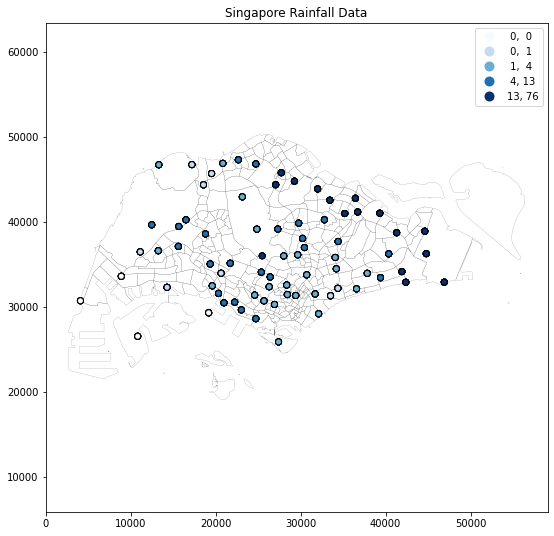

In [46]:
f, ax = plt.subplots(1, figsize=(9, 9))
sz.plot(ax=ax, legend=False, facecolor="none",edgecolor="k",lw=0.1)
rainfall.plot(ax=ax, column='value', legend=True, scheme='Quantiles', legend_kwds={'fmt':'{:.0f}'}, cmap='Blues', edgecolor="k")
ax.set_title('Singapore Rainfall Data')
plt.axis('equal')
plt.show()

In [54]:
rainfall.dtypes

Day_ID           int64
station_id      object
value          float64
id              object
device_id       object
name            object
latitude       float64
longitude      float64
geometry      geometry
dtype: object

In [124]:
rainfall_day=rainfall.query('Day_ID == 3')

In [91]:
extent = min_x, max_x, min_y, max_y = [rainfall.geometry.x.min()-1000, rainfall.geometry.x.max()+1000,
                                       rainfall.geometry.y.min()-1000, rainfall.geometry.y.max()+1000]

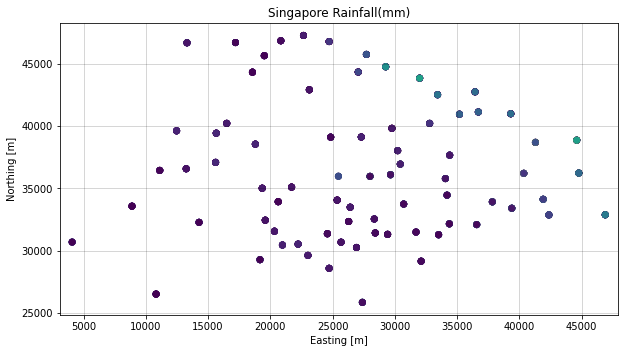

In [92]:
fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(rainfall.geometry.x, rainfall.geometry.y, c=rainfall.value)
ax.set_aspect(1)
ax.set_xlim(*extent[:2])
ax.set_ylim(*extent[2:])
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('Singapore Rainfall(mm)')
ax.grid(c='k', alpha=0.2)

plt.show()

## Make a regular grid

We must make a grid, which represents the points we'd like to predict.

In [60]:
gridx, gridy = np.mgrid[min_x:max_x:500, min_y:max_x:500]

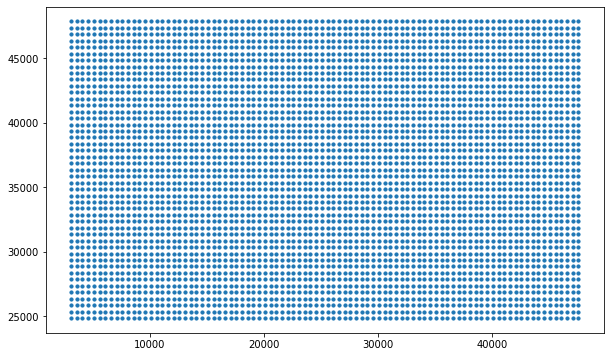

In [62]:
plt.figure(figsize=(10,6))
plt.scatter(gridx, gridy, s=10)

## Interpolation with radial basis function

Now we make an interpolator and use it to predict into the grid 'cells'.

In [97]:
from scipy.interpolate import Rbf

# Make an n-dimensional interpolator. 

rbfi = Rbf(rainfall_day.geometry.x, rainfall_day.geometry.y, rainfall_day.value)

# Predict on the regular grid. Line 5.
di = rbfi(gridx, gridy)

Let's plot the result. First, we'll need the min and max of the combined sparse and gridded data, so we can plot them with the same colourmap ranges:

In [98]:
mi = np.min(np.hstack([di.ravel(), rainfall_day.value.values]))
ma = np.max(np.hstack([di.ravel(), rainfall_day.value.values]))

Notice the transpose and the `origin='lower'`, to keep everything matched up with the original dataset.

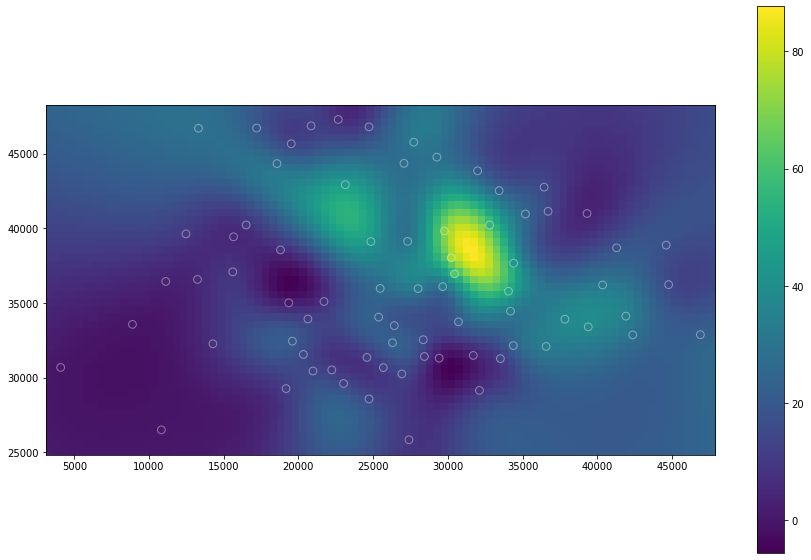

In [99]:
plt.figure(figsize=(15,15))
c1 = plt.imshow(di.T, origin="lower", extent=extent, vmin=mi, vmax=ma)
c2 = plt.scatter(rainfall_day.geometry.x, rainfall_day.geometry.y, s=60, c=rainfall_day.value, edgecolor='#ffffff66', vmin=mi, vmax=ma)

plt.colorbar(c1, shrink=0.67)
plt.show()

The circles (the data) are the same colour as the grid (the model), so we can see that the error on this prediction is almost zero. In fact, the default parameters force the model to pass through all the data points (interpolation, as opposed to estimation or approximation).

The `Rbf()` interpolator has [a few options](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html). The most important one is probably `smooth`, which is the thing to increase if you end up with a singular matrix (because it can't converge on a solution). Anything above 0 relaxes the constraint that the surface must pass through every point. If you get an error, you probably need to change the smoothing.

You can also change the `function` (default is `multiquadric`, which also has an `epsilon` parameter to vary the range of influence of each point).

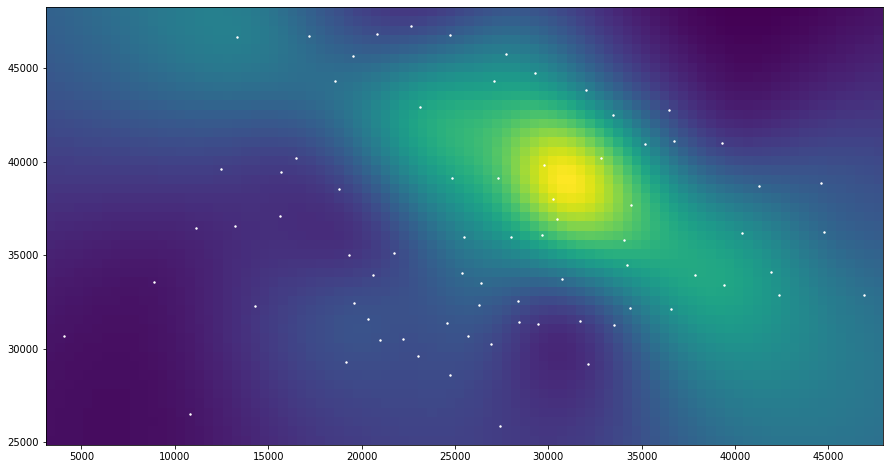

In [100]:
rbfi = Rbf(rainfall_day.geometry.x, rainfall_day.geometry.y, rainfall_day.value, smooth=0.2)
di = rbfi(gridx, gridy)

fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(di.T, origin="lower", extent=extent)
plt.scatter(rainfall_day.geometry.x, rainfall_day.geometry.y, s=2, c='w')
plt.show()


We can also make a histogram and kernel density estimation of the errors, by making predictions at the original input locations:

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value', ylabel='Density'>

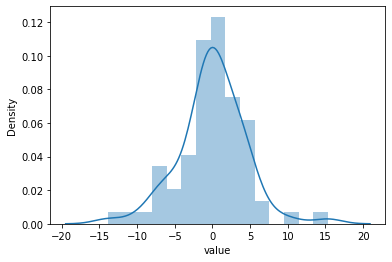

In [78]:
value_hat = rbfi(rainfall_day.geometry.x, rainfall_day.geometry.y)

sb.distplot(value_hat - rainfall_day.value)

With the smoothing set to 0.2, we end up with a smoother surface, but pay for it with larger errors.

## Interpolation with `scipy.griddata()`

The `Rbf()` interpolator is the one to know about, because it has lots of useful parameters. It's probably the only one you need to know. But there is also `scipy.griddata()`. For example see [this SciPy recipe](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.griddata.html).

The interface is slightly different &mdash; we have to pass a single array of the coordinates (the (x, y) locations of the points we know). We also pass the values to interpolate, and the grids.

The function will not accept Pandas `Series` objects, so we'll use the `Series.values` attribute to get at the NumPy array representation.

First, let's make the 2D array of coordinates:

In [86]:
points = np.vstack((rainfall_day.geometry.x,rainfall_day.geometry.y)).T

In [87]:
points.shape

(75, 2)

The grdding step is easy. We'll try three different algorithms:

In [88]:
from scipy.interpolate import griddata

grid_z0 = griddata(points, rainfall_day.value.values, (gridx, gridy), method='nearest')
grid_z1 = griddata(points, rainfall_day.value.values, (gridx, gridy), method='linear')
grid_z2 = griddata(points, rainfall_day.value.values, (gridx, gridy), method='cubic')

Inspect the results.

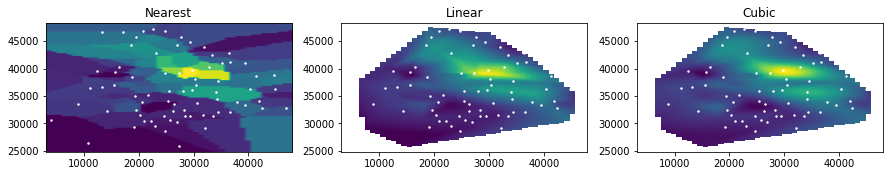

In [89]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

ax = axs[0]
ax.imshow(grid_z0, origin='lower', extent=extent)
ax.scatter(rainfall_day.geometry.x,rainfall_day.geometry.y, s=2, c='w')
ax.set_title('Nearest')

ax = axs[1]
ax.imshow(grid_z1, origin='lower', extent=extent)
ax.scatter(rainfall_day.geometry.x,rainfall_day.geometry.y, s=2, c='w')
ax.set_title('Linear')

ax = axs[2]
ax.imshow(grid_z2, origin='lower', extent=extent)
ax.scatter(rainfall_day.geometry.x,rainfall_day.geometry.y, s=2, c='w')
ax.set_title('Cubic')

plt.show()

## Using `sklearn.gaussian_process`

Modeling with a Gaussian process is equivalent to kriging. Conveniently, the popular machine learning library `scikit-learn` has a Gaussian process modeling tool.

In [125]:
from sklearn.gaussian_process.kernels import RBF

kernel = RBF(length_scale=1000)

The main hyperparameters are the kernel, which we just defined, and `alpha`, which controls the smoothness. Larger values imply mmore noise in the input data, and result in smoother grids; default is very small: 1 &times; 10<sup>-9</sup>.

In [126]:
from sklearn.gaussian_process import GaussianProcessRegressor

gp = GaussianProcessRegressor(normalize_y=True,
                              alpha=0.1,  # Larger values imply more noise in the input data.
                              kernel=kernel)

gp.fit(points, rainfall_day.value.values)

GaussianProcessRegressor(alpha=0.1, kernel=RBF(length_scale=1e+03),
                         normalize_y=True)

To make a prediction, we need to construct the X matrix: (x, y) coordinates in 2 columns:

In [127]:
X_grid = np.stack([gridx.ravel(), gridy.ravel()]).T

Now we can make a prediction:

In [128]:
y_grid = gp.predict(X_grid).reshape(gridx.shape)

And plot the predicted grid with the input data using the same colourmap:

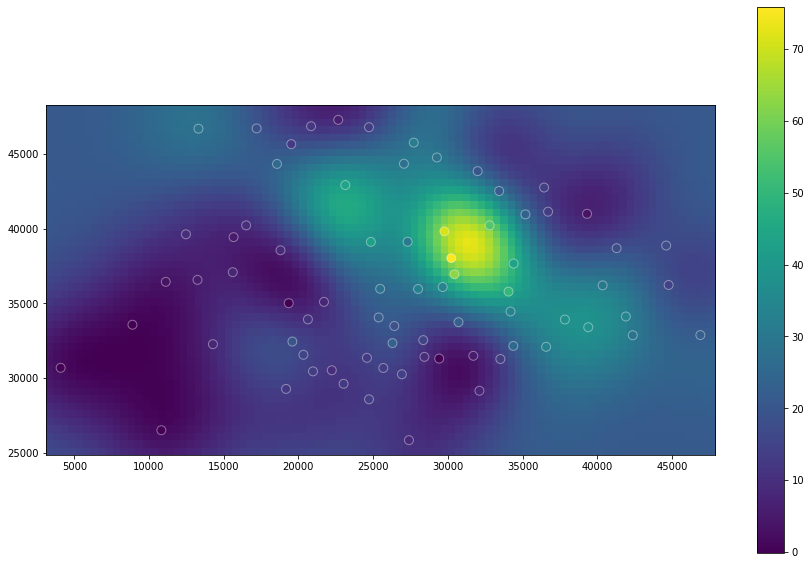

In [129]:
# Compute min and max of all the data:
mi = np.min(np.hstack([y_grid.ravel(), rainfall_day.value.values]))
ma = np.max(np.hstack([y_grid.ravel(), rainfall_day.value.values]))

# Plot it all.
plt.figure(figsize=(15,15))
im = plt.imshow(y_grid.T, origin='lower', extent=extent, vmin=mi, vmax=ma)
pts = plt.scatter(rainfall_day.geometry.x, rainfall_day.geometry.y, c=rainfall_day.value, s=80, edgecolor='#ffffff66', vmin=mi, vmax=ma)
plt.colorbar(im, shrink=0.67)
plt.show()

As before, we can compute the error by making a prediction on the original (x, y) values and comparing to the actual measured porosities at those locations:

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value', ylabel='Density'>

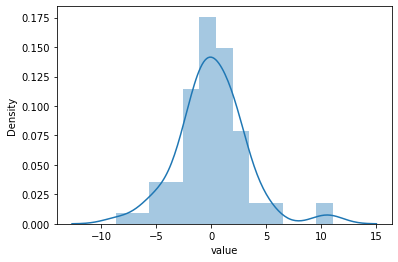

In [130]:
value_hat = gp.predict(points)

sb.distplot(value_hat - rainfall_day.value)

# References

[Agile Scientific](https://colab.research.google.com/github/agile-geoscience/xlines/blob/master/notebooks/11_Gridding_map_data.ipynb#scrollTo=DAwZjB9crEDH)
